In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import pandas as pd
from pandas.api.types import is_integer_dtype, is_float_dtype

load_dotenv()
os.chdir(os.getenv('BASE_PATH'))


In [2]:
df = pd.read_csv('data/raw/retail_store_inventory.csv')
df.drop(columns=['Date', 'Store ID', 'Product ID'], axis=1, inplace=True)

In [3]:
df = df.rename(columns={'Inventory Level': 'Inventory',
                        'Units Sold': 'Sales',
                        'Units Ordered': 'Orders',
                        'Demand Forecast': 'Demand',
                        'Weather Condition': 'Weather',
                        'Holiday/Promotion': 'Promotion',
                        'Competitor Pricing': 'Competitor Price'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  int64  
 3   Sales             73100 non-null  int64  
 4   Orders            73100 non-null  int64  
 5   Demand            73100 non-null  float64
 6   Price             73100 non-null  float64
 7   Discount          73100 non-null  int64  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  int64  
 10  Competitor Price  73100 non-null  float64
 11  Seasonality       73100 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


In [5]:
def downcast_ints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    int_cols = [c for c in df.columns if is_integer_dtype(df[c])]
    for c in int_cols:
        s = df[c]
        if s.min() >= 0:
            df[c] = pd.to_numeric(s, downcast="unsigned")  # -> uint8/16/32/64
        else:
            df[c] = pd.to_numeric(s, downcast="integer")   # -> int8/16/32/64
    return df

def optimize_df(df: pd.DataFrame) -> pd.DataFrame:
    start = df.memory_usage(deep=True).sum()
    out = df.copy()

    # 1) Downcast integers
    out = downcast_ints(out)

    # 2) Downcast floats
    float_cols = [c for c in out.columns if is_float_dtype(out[c])]
    out[float_cols] = out[float_cols].apply(pd.to_numeric, downcast="float")  # -> float32

    end = out.memory_usage(deep=True).sum()
    print(f"Memory: {start/1024**2:.2f} MB → {end/1024**2:.2f} MB "
          f"({(1 - end/start)*100:.1f}% reduction)")
    return out

df = optimize_df(df)
df.info()


Memory: 22.03 MB → 18.89 MB (14.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  uint16 
 3   Sales             73100 non-null  uint16 
 4   Orders            73100 non-null  uint8  
 5   Demand            73100 non-null  float32
 6   Price             73100 non-null  float32
 7   Discount          73100 non-null  uint8  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  uint8  
 10  Competitor Price  73100 non-null  float32
 11  Seasonality       73100 non-null  object 
dtypes: float32(3), object(4), uint16(2), uint8(3)
memory usage: 3.6+ MB


In [6]:
x = df.drop(columns=['Demand'])
y = df['Demand']

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x['Category'] = label_encoder.fit_transform(x['Category'])
x['Region'] = label_encoder.fit_transform(x['Region'])
x['Weather'] = label_encoder.fit_transform(x['Weather'])
x['Seasonality'] = label_encoder.fit_transform(x['Seasonality'])
x['Promotion'] = label_encoder.fit_transform(x['Promotion'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

In [10]:
class HParamMetrics:

  def __init__(self, est):
    self.est = est
    self.train_rn = None
    self.y_pred = None
    self.test_r2 = None
    self.mse = None
    self.rmse = None
    self.mae = None

In [11]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, x_train, y_train, x_test, y_test, HPM):
  # calculate metrics
  HPM.train_r2 = model.score(x_train, y_train)
  HPM.y_pred = model.predict(x_test)
  HPM.test_r2 = r2_score(y_test, HPM.y_pred)
  HPM.mse = mean_squared_error(y_test, HPM.y_pred)
  HPM.rmse = np.sqrt(HPM.mse)
  HPM.mae = mean_absolute_error(y_test, HPM.y_pred)

  #prepare the table data
  metrics = [
    ["Training R^2 Score", f"{HPM.train_r2:.4f}"],
    ["Testing R^2 Score", f"{HPM.test_r2:.4f}"],
    ["Mean Squared Error (MSE)", f"{HPM.mse:.2f}"],
    ["Root Mean Squared Error (RMSE)", f"{HPM.rmse:.2f}"],
    ["Mean Absolute Error (MAE)", f"{HPM.mae:.2f}"],
  ]

  # Print the table
  print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

initial_HPM = HParamMetrics(lr.fit(x_train, y_train))

In [13]:
evaluate_model(lr, x_train, y_train, x_test, y_test, initial_HPM)

+--------------------------------+---------+
| Metric                         |   Value |
+================================+=========+
| Training R^2 Score             |  0.9937 |
+--------------------------------+---------+
| Testing R^2 Score              |  0.9938 |
+--------------------------------+---------+
| Mean Squared Error (MSE)       | 75.34   |
+--------------------------------+---------+
| Root Mean Squared Error (RMSE) |  8.68   |
+--------------------------------+---------+
| Mean Absolute Error (MAE)      |  7.51   |
+--------------------------------+---------+


In [14]:
print(initial_HPM.est)

LinearRegression()


In [15]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
               'positive': [True,False]}


rs = RandomizedSearchCV(
	initial_HPM.est,
	param_distributions=param_dist,
	verbose=1,
  cv=10,
)

rs.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,LinearRegression()
,param_distributions,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'n_jobs': [1, 5, ...], 'positive': [True, False]}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [16]:
rs.cv_results_

{'mean_fit_time': array([0.04603364, 0.03215837, 0.03543344, 0.01933067, 0.03482847,
        0.03283951, 0.01412914, 0.03288829, 0.01252553, 0.038099  ]),
 'std_fit_time': array([0.00830504, 0.0029184 , 0.00664002, 0.01768624, 0.00240163,
        0.00308   , 0.00085422, 0.00213591, 0.00115521, 0.00383671]),
 'mean_score_time': array([0.00164924, 0.00181117, 0.00166039, 0.00187356, 0.00164399,
        0.0017138 , 0.00184903, 0.00192797, 0.00207267, 0.00223904]),
 'std_score_time': array([0.00036253, 0.00032657, 0.00037635, 0.00049243, 0.00054758,
        0.00036794, 0.00064839, 0.00060752, 0.0009681 , 0.00087439]),
 'param_positive': masked_array(data=[True, True, True, False, True, True, False, True,
                    False, True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=True),
 'param_n_jobs': masked_array(data=[1, 10, 15, 15, 1, None, 1, 15, 1, 15],
              mask=[False, False, False, Fal

In [17]:
df.columns

Index(['Category', 'Region', 'Inventory', 'Sales', 'Orders', 'Demand', 'Price',
       'Discount', 'Weather', 'Promotion', 'Competitor Price', 'Seasonality'],
      dtype='object')

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression

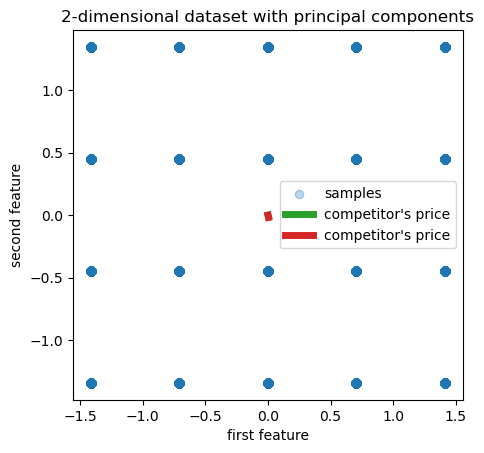

In [26]:
rng = np.random.RandomState(0)
X = x
pca = PCA(n_components=2).fit(X)


plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=label,
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state='rng')

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

In [ ]:
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.18045418 0.14467314]
Cumulative: [0.18045418 0.32512732]


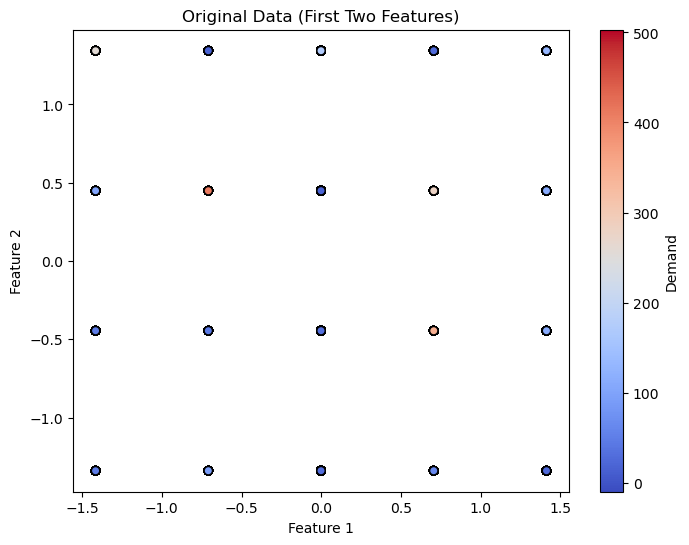

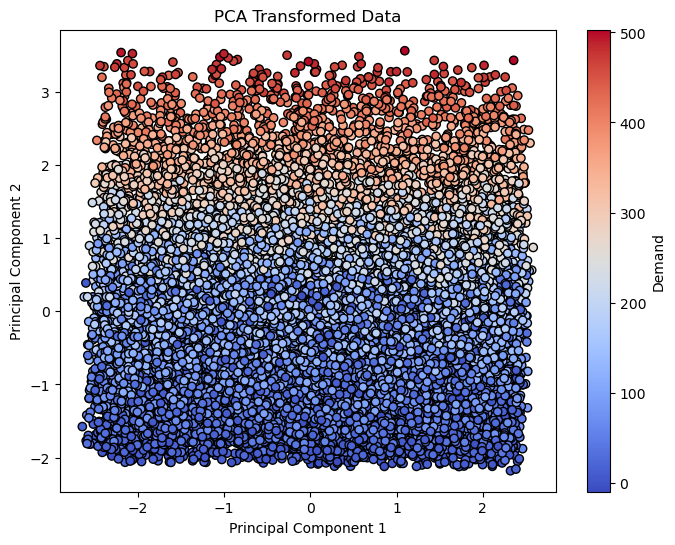

In [ ]:
# plt.figure(figsize=(8,6))
# plt.scatter(x_pre_pca[:, 0], x_pre_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.title("Original Data (First Two Features)")
# plt.colorbar(label="Demand")
# plt.show()

# plt.figure(figsize=(8,6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("PCA Transformed Data")
# plt.colorbar(label="Demand")
# plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.2)

In [ ]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

In [ ]:
# def create_pie(y_pred, y_test, margin):
#   scores = [1 if abs(pred - test) <= margin else 0 for pred, test in zip(y_pred, y_test)]

#   scores_tuple = (scores.count(0), scores.count(1))
#   plt.figure(figsize=(8,6))
#   plt.pie(scores_tuple, labels=('0', '1'))
#   plt.title(f"Predictions within {margin} of actual demand")
#   plt.legend(labels=[f'Not within {margin}: {scores_tuple[0]}', f'Within {margin}: {scores_tuple[1]}'])

#   plt.show()

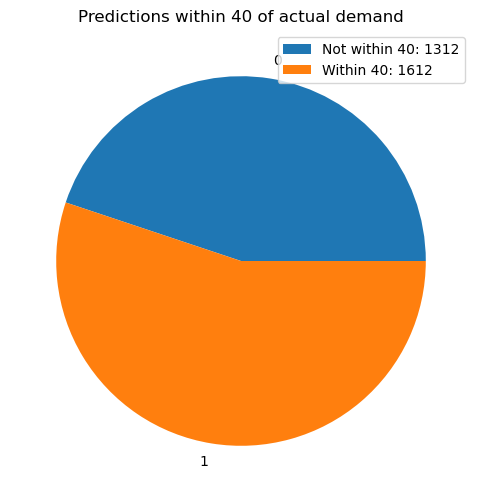

In [ ]:
# create_pie(y_pred, y_test, 40)